In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from pymatching import Matching
import networkx as nx

In [37]:
l = 3 # number of sublattice points (2 for toric code) or primal/dual
Nrep = 400 # number of iterations
L_list = [6,8,10]
prob_l = 0.1 # loss rate
pz0_list = np.linspace(0.001,0.01,10)
fail_prob_z0 = np.zeros((len(L_list),len(pz0_list)))

for i_L, r in enumerate(L_list):
    print("L= ", r)
    r1 = r # dimension of cube
    r2 = r # dimension of cube
    r3 = r # dimension of cube

    # star stabilzers
    Sx = np.zeros((r1*r2*r3,l*r1*r2*r3))
    for ix in range(r1):
        for iy in range(r2):
            for iz in range(r3):
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))] = 1
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+1] = 1
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+2] = 1
                Sx[ix + r1*(iy+ r2*iz), l*( ((ix-1)%r1) + r1*(iy+ r2*iz))] = 1
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*( ((iy-1)%r2)+ r2*iz) )+1] = 1
                Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2* ((iz-1)%r3)) )+2] = 1

    logicals = np.zeros((3,l*r1*r2*r3))
    ## x ops
    for i1 in range(r2):
        logicals[0,np.ix_(3*np.arange(i1*r1,r1*r2*r3,r1*r2))] = np.ones(r3)
    for i1 in range(r3):
        logicals[1,np.ix_(1+ 3*(i1*r1*r2+ np.arange(0,r1) ) )] = np.ones(r1)
    logicals[2,2:3*r1*r2+1:3] = np.ones(r1*r2) 

    tic = time.time()

    def compute_eff_Sx(Sx,loss_inds,remain_inds):
        Sx_new = []
        inds_new = []
        Sx_old = np.copy(Sx)
        inds_old = list(range(r1*r2*r3))
        for loss_index in loss_inds:
            st_ind = np.argwhere(Sx_old[:,loss_index]>0)
            st_ind = list(st_ind[:,0])
            if len(st_ind)==2:
                inds_new.append(st_ind)
                Stot = np.zeros(l*r1*r2*r3)
                for i_remove in st_ind:
                    inds_old.remove(i_remove)
                    Stot += Sx_old[i_remove,:]
                Sx_new.append(list(Stot%2)) 
                Sx_old[st_ind,:] = 0
            elif len(st_ind)==1:
                st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
                inds_new[st_new_ind][:] += st_ind
                inds_old.remove(st_ind[0])
                Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
                Sx_old[st_ind,:] = 0
            else:
                st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
                if len(st_new_ind)>1:
                    st_new_ind = list(st_new_ind[:,0])
                    inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                    Stot = np.zeros(l*r1*r2*r3)
                    for i_remove in st_new_ind:
                        Stot += np.array(Sx_new)[i_remove,:]        
                    Sx_new[st_new_ind[0]] = list(Stot%2)
                    del inds_new[st_new_ind[1]]
                    del Sx_new[st_new_ind[1]]
        Sx_new = np.array(Sx_new, dtype=int)

        for loss_index in loss_inds:
            st_ind = np.argwhere(Sx_old[:,loss_index]>0)
            st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
            assert len(st_ind)+len(st_new_ind)==0

        num_Sx_red = len(inds_new)+len(inds_old)
        Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
        Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
        if len(inds_new)>0:
            Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

        keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
        Sx_red = Sx_red[:,keep_cols]

        qubits_to_plot = remain_inds[keep_cols]
        return Sx_red, qubits_to_plot

    ##################
    def netx_Sx(Sx_red,overlap,qubits_to_plot):
        inds_to_keep = list(range(np.size(Sx_red,1)))
        nl = []
        counter = 0
        i = 0 
        while counter < np.size(Sx_red,1):
            edge = inds_to_keep[i]
            ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
            if len(ovlp_inds)>0:
                for j in ovlp_inds[::-1,0]:
                    inds_to_keep.remove(inds_to_keep[i+1+j])
                counter += (len(ovlp_inds)+1)
                nl.append(len(ovlp_inds)+1)
            else:
                counter += 1
                nl.append(1)
            i += 1

        Sx_red_netx = Sx_red[:,inds_to_keep]
        # remain_qubits = remain_inds[keep_cols[inds_to_keep]]
        remain_qubits = qubits_to_plot[inds_to_keep]
        nl = np.array(nl)
        return Sx_red_netx, remain_qubits, inds_to_keep, nl

    for i_n in range(Nrep):
        ## loss error
        error_loss = np.random.rand(l*r1*r2*r3) 
        loss_inds = np.argwhere(error_loss < prob_l)[:,0]
        remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
        # percolate_y, percolate_x = does_loss_percolate(loss_inds) 
        # loss_percolate = (percolate_x or percolate_y)
        # if loss_percolate:
            # # fail_prob_z +=  1
            # loss_prob +=  1
            # continue
        error_loss[loss_inds] = 1
        error_loss[remain_inds] = 0

        Sx_red, qubits_to_plot = compute_eff_Sx(Sx,loss_inds,remain_inds)

        lost_qubits = np.array(list(set(np.arange(l*r1*r2*r3)) - set(qubits_to_plot)))
        # percolate_y, percolate_x = does_loss_percolate(lost_qubits)
        # loss_percolate = (percolate_x or percolate_y)
        # if loss_percolate:
        #     # fail_prob_z +=  1
        #     loss_prob +=  1
        #     continue

        overlap = Sx_red.T@Sx_red
        Sx_red_netx, remain_qubits, inds_to_keep, nl = netx_Sx(Sx_red,overlap,qubits_to_plot)
        num_edge = len(remain_qubits) 
        ################
        for i_p, prob_z in enumerate(pz0_list):

            pl = (1-(1-2*prob_z)**nl)/2
            ########## weights on square lattice ############
            weights = np.zeros(l*r1*r2*r3)
            weights[remain_qubits] = np.log((1-pl)/pl) 

            inds_to_keep_2 = list(range(np.size(Sx_red,1)))
            for i in range(num_edge):
                edge = inds_to_keep[i]
                ovlp_inds = np.argwhere(overlap[edge,inds_to_keep_2[i+1:]]==2)
                if len(ovlp_inds)>0:
                    for j in ovlp_inds[::-1,0]:
                        weights[qubits_to_plot[inds_to_keep_2[i+1+j]]] = np.log((1-pl[i])/pl[i]) 

            assert len(np.argwhere(weights>0))== len(qubits_to_plot)

            error_table = np.random.rand(num_edge) < pl
            zflip_inds = np.argwhere(error_table == True)[:,0]
            no_zflip_inds = np.argwhere(error_table == False)[:,0]
            error_z_orig = np.zeros(l*r1*r2*r3,dtype=int)
            error_z_orig[remain_qubits[zflip_inds]] = 1

            if num_edge > 1:
                m_orig = Matching(Sx,spacelike_weights=weights)
            else:
                print("how?")
                fail_prob_z0[i_L,i_p] +=  1
                continue

            # find syndrome
            syndrome_x_orig = Sx@error_z_orig % 2
            synd_x_inds = np.argwhere(syndrome_x_orig > 0)
            if len(synd_x_inds)>0:
                rec2_orig = m_orig.decode(syndrome_x_orig)
                rec2_orig_inds = np.argwhere(rec2_orig > 0)[:,0]

                error_rec_orig = (rec2_orig + error_z_orig )%2
                s_orig = np.dot( error_rec_orig , logicals.T) %2 
                if np.sum(s_orig)  > 0:
                    fail_prob_z0[i_L,i_p] +=  1
    toc = time.time()
    print("Finished in %d secs" % (toc-tic))

print("Done!")

L=  6
Finished in 337 secs
L=  8
Finished in 1391 secs
L=  10
Finished in 6107 secs
Done!


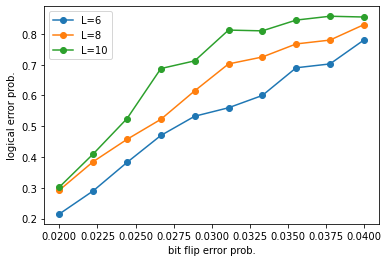

In [38]:
for i_L, L in enumerate(L_list):
    plt.plot(pz0_list,fail_prob_z0[i_L,:]/Nrep,"o-", label="L=%d" % (L))
    
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
# plt.yscale("log")
plt.legend()
plt.show()

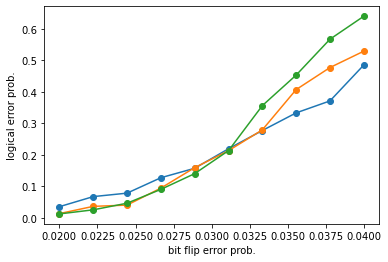

In [24]:
plt.plot(pz0_list,fail_prob_z0.T/Nrep,"o-")
# plt.plot(px_list,fail_prob_x.T/Nrep,"x-")
plt.xlabel("bit flip error prob.")
plt.ylabel("logical error prob.")
# plt.yscale("log")
plt.show()

In [27]:
repeat = 1
Nrep_loss = 1 # number of iterations
Nrep_flip = 1 # number of iterations
L_list = [6]#[16,24,32] # [8,12,16,20]
prob_l = 0.1 # loss rate
pz_list = [0.02]#np.linspace(0.01,0.1,6) #np.arange(0.02,0.071,0.005) 

for i_rep in np.arange(repeat):
    for i_L, r in enumerate(L_list):
        print("L= ", r, " rep= ", i_rep)
        fail_prob_z = np.zeros(len(pz_list))
        loss_prob = 0

        r1 = r # dimension of cube
        r2 = r # dimension of cube
        r3 = r # dimension of cube
        logicals = np.zeros((3,l*r1*r2*r3))
        ## x ops
        for i1 in range(r2):
            logicals[0,np.ix_(3*np.arange(i1*r1,r1*r2*r3,r1*r2))] = np.ones(r3)
        for i1 in range(r3):
            logicals[1,np.ix_(1+ 3*(i1*r1*r2+ np.arange(0,r1) ) )] = np.ones(r1)
        logicals[2,2:3*r1*r2+1:3] = np.ones(r1*r2) 


        tic = time.time()

        def does_loss_percolate(loss_inds):
            Gy = nx.Graph()
            Gy.add_nodes_from(np.arange(r1*r2))
            Gx = nx.Graph()
            Gx.add_nodes_from(np.arange(r1*r2))


            for i2 in range(r2):
                for i1 in range(r1):
                    ind1 = i2*r1+ i1
                    ind2 = i2*r1 + ((i1+1)%r1)
                    # cylinder along y
                    if 2*ind1 in loss_inds:
                        Gy.add_edge(ind1,ind2)
                    if ind1 +r1 < r1*r2 and 2*ind1+1 in loss_inds:
                        Gy.add_edge(ind1,ind1+r1)
                    # cylinder along x
                    ind2 = ((i2+1)%r2)*r1 + i1
                    if 2*ind1+1 in loss_inds:
                        Gx.add_edge(ind1,ind2)
                    if i1+1 < r1 and 2*ind1 in loss_inds:
                        Gx.add_edge(ind1,ind1+1)

            first_row = np.arange(r1)
            last_row = np.arange((r2-1)*r1,r2*r1)
            path_y = False
            for i_first in first_row:
                for i_last in last_row:
                    if nx.has_path(Gy,i_first,i_last):
                        if (i_first - i_last )%r1 ==0: # or 2*i_last+1 in loss_inds
                            path_y = True
                            break
                if path_y:
                    break

            first_col = np.arange(0,(r2-1)*r1+1,r1)
            last_col = np.arange(r1-1,r2*r1+1,r1)
            path_x = False
            for i_first in first_col:
                for i_last in last_col:
                    if nx.has_path(Gx,i_first,i_last):
                        if  int(i_first/r1) == int(i_last/r1): # or 2*i_last in loss_inds
                            path_x = True
                            break
                if path_x:
                    break

            for i in range(len(loss_inds)):
                ind1 = int(loss_inds[i]/2)
                if loss_inds[i] % 2 == 0 :
                    ind2 = int(int(loss_inds[i]/2)/r1)*r1 + (((int(loss_inds[i]/2)%r1)+1)%r1)
                    assert Gy.has_edge(ind1,ind2)
                    ind2 = ind1 + 1
                    if (int(loss_inds[i]/2)%r1)+1 < r1:
                        assert Gx.has_edge(ind1,ind2)     
                else:
                    ind2 = ind1 + r1
                    if ind2 < r1*r2:
                        assert Gy.has_edge(ind1,ind2)
                    ind2 = ((int(int(loss_inds[i]/2)/r1)+1)%r2)*r1 + (int(loss_inds[i]/2)%r1)
                    assert Gx.has_edge(ind1,ind2)
            return path_y,path_x

        def compute_eff_Sx(Sx,loss_inds,remain_inds):
            Sx_new = []
            inds_new = []
            Sx_old = np.copy(Sx)
            inds_old = list(range(r1*r2*r3))
            for loss_index in loss_inds:
                st_ind = np.argwhere(Sx_old[:,loss_index]>0)
                st_ind = list(st_ind[:,0])
                if len(st_ind)==2:
                    inds_new.append(st_ind)
                    Stot = np.zeros(l*r1*r2*r3)
                    for i_remove in st_ind:
                        inds_old.remove(i_remove)
                        Stot += Sx_old[i_remove,:]
                    Sx_new.append(list(Stot%2)) 
                    Sx_old[st_ind,:] = 0
                elif len(st_ind)==1:
                    st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)[0,0]
                    inds_new[st_new_ind][:] += st_ind
                    inds_old.remove(st_ind[0])
                    Sx_new[st_new_ind] = list((np.array(Sx_new)[st_new_ind,:]+Sx_old[st_ind[0],:]) %2)
                    Sx_old[st_ind,:] = 0
                else:
                    st_new_ind = np.argwhere(np.array(Sx_new)[:,loss_index]>0)
                    if len(st_new_ind)>1:
                        st_new_ind = list(st_new_ind[:,0])
                        inds_new[st_new_ind[0]][:] += inds_new[st_new_ind[1]][:]
                        Stot = np.zeros(l*r1*r2*r3)
                        for i_remove in st_new_ind:
                            Stot += np.array(Sx_new)[i_remove,:]        
                        Sx_new[st_new_ind[0]] = list(Stot%2)
                        del inds_new[st_new_ind[1]]
                        del Sx_new[st_new_ind[1]]
            Sx_new = np.array(Sx_new, dtype=int)

            for loss_index in loss_inds:
                st_ind = np.argwhere(Sx_old[:,loss_index]>0)
                st_new_ind = np.argwhere(Sx_new[:,loss_index]>0)
                assert len(st_ind)+len(st_new_ind)==0

            num_Sx_red = len(inds_new)+len(inds_old)
            Sx_red = np.zeros((num_Sx_red,len(remain_inds)),dtype=int)
            Sx_red[0:len(inds_old),:] = Sx_old[np.ix_(inds_old,remain_inds)]
            if len(inds_new)>0:
                Sx_red[len(inds_old):,:] = Sx_new[:,remain_inds]

            keep_cols = np.argwhere(np.sum(Sx_red,axis=0)>0)[:,0]
            Sx_red = Sx_red[:,keep_cols]

            qubits_to_plot = remain_inds[keep_cols]
            return Sx_red, qubits_to_plot

        ##################
        def netx_Sx(Sx_red,overlap,qubits_to_plot):
            inds_to_keep = list(range(np.size(Sx_red,1)))
            nl = []
            counter = 0
            i = 0 
            while counter < np.size(Sx_red,1):
                edge = inds_to_keep[i]
                ovlp_inds = np.argwhere(overlap[edge,inds_to_keep[i+1:]]==2)
                if len(ovlp_inds)>0:
                    for j in ovlp_inds[::-1,0]:
                        inds_to_keep.remove(inds_to_keep[i+1+j])
                    counter += (len(ovlp_inds)+1)
                    nl.append(len(ovlp_inds)+1)
                else:
                    counter += 1
                    nl.append(1)
                i += 1

            Sx_red_netx = Sx_red[:,inds_to_keep]
            # remain_qubits = remain_inds[keep_cols[inds_to_keep]]
            remain_qubits = qubits_to_plot[inds_to_keep]
            nl = np.array(nl)
            return Sx_red_netx, remain_qubits, inds_to_keep, nl

        ##################
        # star stabilzers
        Sx = np.zeros((r1*r2*r3,l*r1*r2*r3))
        for ix in range(r1):
            for iy in range(r2):
                for iz in range(r3):
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+1] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2*iz))+2] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*( ((ix-1)%r1) + r1*(iy+ r2*iz))] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*( ((iy-1)%r2)+ r2*iz) )+1] = 1
                    Sx[ix + r1*(iy+ r2*iz), l*(ix + r1*(iy+ r2* ((iz-1)%r3)) )+2] = 1


        for i_loss in range(Nrep_loss):

           ## loss error
            error_loss = np.random.rand(l*r1*r2*r3) 
            loss_inds = np.argwhere(error_loss < prob_l)[:,0]
            remain_inds = np.argwhere(error_loss >= prob_l)[:,0]
            # percolate_y, percolate_x = does_loss_percolate(loss_inds) 
            # loss_percolate = (percolate_x or percolate_y)
            # if loss_percolate:
                # # fail_prob_z +=  1
                # loss_prob +=  1
                # continue
            error_loss[loss_inds] = 1
            error_loss[remain_inds] = 0

            Sx_red, qubits_to_plot = compute_eff_Sx(Sx,loss_inds,remain_inds)

            lost_qubits = np.array(list(set(np.arange(l*r1*r2*r3)) - set(qubits_to_plot)))
            # percolate_y, percolate_x = does_loss_percolate(lost_qubits)
            # loss_percolate = (percolate_x or percolate_y)
            # if loss_percolate:
            #     # fail_prob_z +=  1
            #     loss_prob +=  1
            #     continue

            overlap = Sx_red.T@Sx_red
            Sx_red_netx, remain_qubits, inds_to_keep, nl = netx_Sx(Sx_red,overlap,qubits_to_plot)
            num_edge = len(remain_qubits) 
            ################
            for i_p, prob_z in enumerate(pz_list):
                for i_n in range(Nrep_flip):

                    pl = (1-(1-2*prob_z)**nl)/2
                    ########## weights on square lattice ############
                    weights = np.zeros(l*r1*r2*r3)
                    weights[remain_qubits] = np.log((1-pl)/pl) 

                    inds_to_keep_2 = list(range(np.size(Sx_red,1)))
                    for i in range(num_edge):
                        edge = inds_to_keep[i]
                        ovlp_inds = np.argwhere(overlap[edge,inds_to_keep_2[i+1:]]==2)
                        if len(ovlp_inds)>0:
                            for j in ovlp_inds[::-1,0]:
                                weights[qubits_to_plot[inds_to_keep_2[i+1+j]]] = np.log((1-pl[i])/pl[i]) 

                    assert len(np.argwhere(weights>0))== len(qubits_to_plot)

                    error_table = np.random.rand(num_edge) < pl
                    zflip_inds = np.argwhere(error_table == True)[:,0]
                    no_zflip_inds = np.argwhere(error_table == False)[:,0]
                    error_z_orig = np.zeros(l*r1*r2*r3,dtype=int)
                    error_z_orig[remain_qubits[zflip_inds]] = 1

                    if num_edge > 1:
                        m_orig = Matching(Sx,spacelike_weights=weights)
                    else:
                        print("how?")
                        fail_prob_z[i_p] +=  1
                        continue

                    # find syndrome
                    syndrome_x_orig = Sx@error_z_orig % 2
                    synd_x_inds = np.argwhere(syndrome_x_orig > 0)
                    if len(synd_x_inds)>0:
                        rec2_orig = m_orig.decode(syndrome_x_orig)
                        rec2_orig_inds = np.argwhere(rec2_orig > 0)[:,0]

                        error_rec_orig = (rec2_orig + error_z_orig )%2
                        s_orig = np.dot( error_rec_orig , logicals.T) %2 
                        if np.sum(s_orig)  > 0:
                            fail_prob_z[i_p] +=  1

        toc = time.time()
        print("Finished in %d secs" % (toc-tic))
        fname = "data_loss_fcts/" + "p_%.2f_L_%d_i_%d_new.npz" % (prob_l,r,i_rep)
        # np.savez(fname, pz_list=pz_list, loss_prob=loss_prob, fail_prob_z=fail_prob_z, Nrep_loss=Nrep_loss, Nrep_flip=Nrep_flip)

    print("Done!")

L=  6  rep=  0
Finished in 0 secs
Done!
